In [1]:
import geopandas as gpd
import numpy as np

import pygmo as pg

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily as ctx
%matplotlib inline

In [2]:
n_sensors = 20

## Load Data

Processed in population_data.ipynb notebook.

In [3]:
tyne_oa = gpd.read_file("data/tyne_oa")
tyne_oa.head()

oa11cd    lad11cd           X           Y  Population  \
0  E00042042  E08000021  421259.393  564639.754         310   
1  E00042043  E08000021  420448.616  564819.213         304   
2  E00042044  E08000021  420509.207  564622.209         246   
3  E00042045  E08000021  421551.722  564088.460         201   
4  E00042046  E08000021  422116.597  563648.529         424   

                                            geometry  
0  POLYGON ((421301.772 564928.429, 421301.755 56...  
1  POLYGON ((420572.364 564892.821, 420572.312 56...  
2  POLYGON ((420492.559 564780.806, 420492.590 56...  
3  POLYGON ((421543.715 563955.116, 421542.251 56...  
4  POLYGON ((422292.813 563736.716, 422265.374 56...

In [4]:
populations = tyne_oa["Population"]

## Calculate Distances Between Output Areas

In [5]:
centroids = np.array([tyne_oa["X"], tyne_oa["Y"]]).T
centroids.shape

(952, 2)

In [6]:
dist_sq = np.sum((centroids[:, np.newaxis, :] - centroids[np.newaxis, :, :]) ** 2,
                 axis = -1)

distances = np.sqrt(dist_sq)

Max distance of 16923.71770783074 m is between E00042743 and E00139704


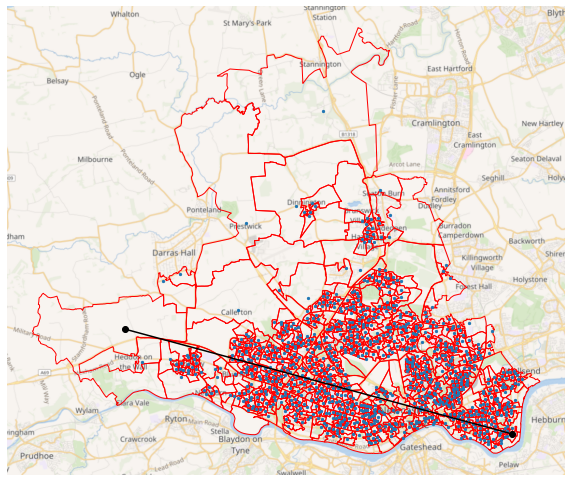

In [7]:
max_idx = np.where(distances == distances.max())[0]
print("Max distance of",
      distances.max(),
      "m is between",
      tyne_oa.iloc[max_idx[0]]["oa11cd"],
      "and", tyne_oa.iloc[max_idx[1]]["oa11cd"])

ax = tyne_oa.plot(figsize=(10,10), facecolor='none', edgecolor='red')
ctx.add_basemap(ax,
                url="https://maps.wikimedia.org/osm-intl/{z}/{x}/{y}.png",
                crs=tyne_oa.crs)

x = tyne_oa["X"]
y = tyne_oa["Y"]
ax.scatter(x, y, s=5)

x = tyne_oa.iloc[max_idx]["X"]
y = tyne_oa.iloc[max_idx]["Y"]
ax.plot(x, y, 'k-o')

ax.set_axis_off()

## Calculate "satisfaction"

Satisfaction at any output area due to a sensor placed in any other output area.

In [8]:
def distance_to_satisfaction(distance, theta=1):
    return np.exp(- distance / theta)

distance_to_satisfaction = np.vectorize(distance_to_satisfaction)

Text(0, 0.5, 'satisfaction')

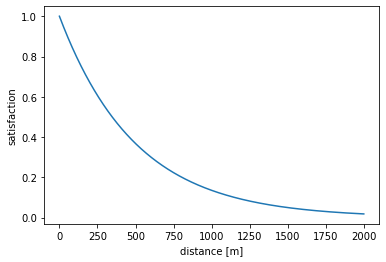

In [9]:
theta = 500

d = np.arange(0, 2000)

plt.plot(d, distance_to_satisfaction(d, theta=theta))
plt.xlabel("distance [m]")
plt.ylabel("satisfaction")

In [10]:
# "satisfaction" at each output area due to a sensor at any other output area
satisfaction = distance_to_satisfaction(distances, theta=theta)

Text(0.5, 1, 'Satisfaction due to sensor at E00042042')

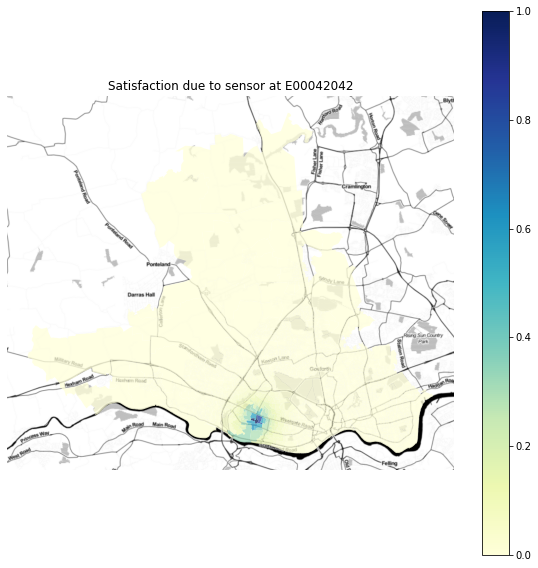

In [11]:
# satisfaction due to sensor at this output area index
sensor_idx = 0

tyne_oa["satisfaction"] = satisfaction[sensor_idx]

ax = tyne_oa.plot(column="satisfaction",
                  figsize=(10,10),alpha=0.75,
                  cmap="YlGnBu", legend=True)

ctx.add_basemap(ax,
                url="http://a.tile.stamen.com/toner/{z}/{x}/{y}.png",
                crs=tyne_oa.crs)

ax.set_axis_off()
plt.title("Satisfaction due to sensor at " +
          tyne_oa.iloc[sensor_idx]["oa11cd"])

In [32]:
def plot_sensors(sensors,
                 figsize=(20,20),
                 print_sensors=True):
    """
    Plot map with sensor locations (red points), output area centroids (black points),
    and satisfaction (shaded areas).
    """
    # only keep satisfactions due to output areas where a sensor is present
    mask_sat = np.multiply(satisfaction, sensors[np.newaxis, :])

    # satisfaction at each output area = satisfaction due to nearest sensor
    max_mask_sat = np.max(mask_sat, axis=1)

    # population weighted average satisfaction
    avg_satisfaction = (populations * max_mask_sat).sum() / populations.sum()
    
    tyne_oa["satisfaction"] = max_mask_sat

    # to make colorbar same size as graph:
    # https://www.science-emergence.com/Articles/How-to-match-the-colorbar-size-with-the-figure-size-in-matpltolib-/
    ax = plt.figure(figsize=figsize).gca()
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    ax = tyne_oa.plot(column="satisfaction",
                      alpha=0.75,
                      cmap="YlGn", legend=True,
                      ax=ax, cax=cax)


    x = tyne_oa[sensors == 1]["X"]
    y = tyne_oa[sensors == 1]["Y"]
    ax.scatter(x, y, s=24, color='r')

    x = tyne_oa[sensors == 0]["X"]
    y = tyne_oa[sensors == 0]["Y"]
    ax.scatter(x, y, s=4, color='k')


    ctx.add_basemap(ax,
                    url="http://a.tile.stamen.com/toner/{z}/{x}/{y}.png",
                    crs=tyne_oa.crs)

    ax.set_axis_off()
    ax.set_title("n_sensors = {:.0f}, satisfaction = {:.2f}".format(sensors.sum(), avg_satisfaction),
                fontsize=20)
    
    # output areas with sensors
    if print_sensors:
        print("Output areas with sensors:",
              tyne_oa[sensors == 1]["oa11cd"].values)

## Baseline 1: place sensors in output areas with largest population

Output areas with sensors: ['E00042147' 'E00042228' 'E00042580' 'E00042600' 'E00042609' 'E00042644'
 'E00042669' 'E00042672' 'E00042673' 'E00042679' 'E00042820' 'E00042877'
 'E00043549' 'E00175564' 'E00175572' 'E00175574' 'E00175578' 'E00175584'
 'E00175591' 'E00175593']


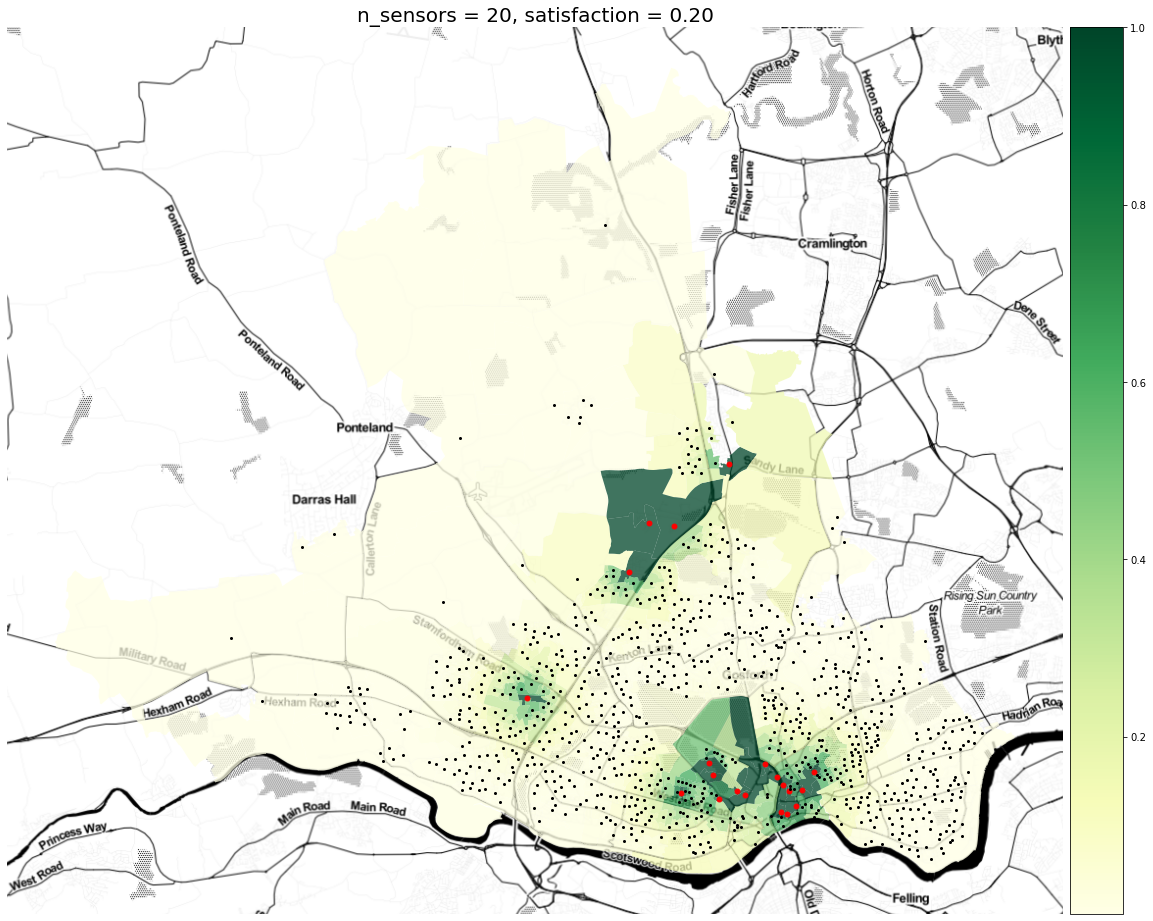

In [33]:
sensors = np.zeros((len(tyne_oa)))

top_idx = tyne_oa["Population"].sort_values(ascending=False).head(n_sensors).index

sensors[top_idx] = 1

plot_sensors(sensors)

## Baseline 2: Place sensors in random output areas

Output areas with sensors: ['E00042139' 'E00042162' 'E00042192' 'E00042342' 'E00042345' 'E00042374'
 'E00042446' 'E00042523' 'E00042555' 'E00042572' 'E00042695' 'E00042705'
 'E00042834' 'E00042839' 'E00042863' 'E00042879' 'E00042882' 'E00042896'
 'E00042898' 'E00043223']


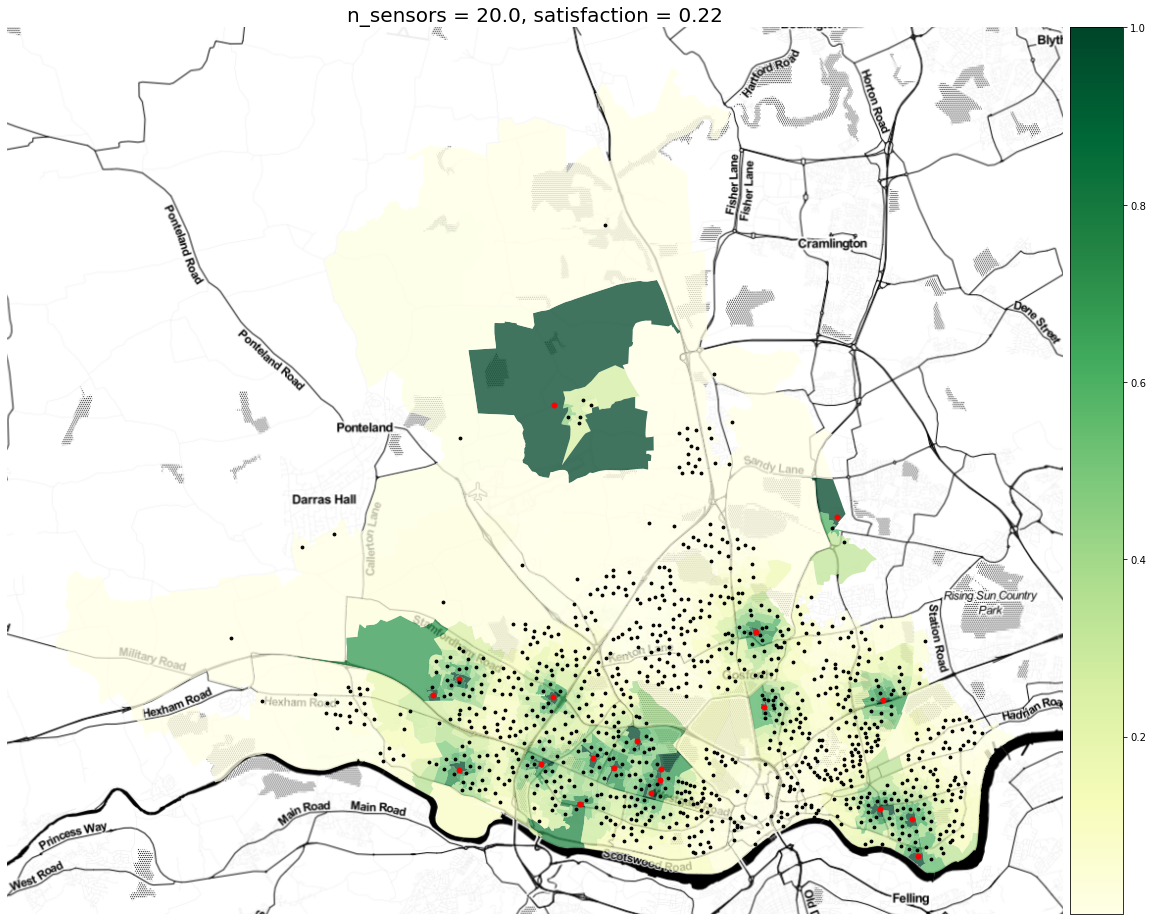

In [14]:
sensors = np.zeros((len(tyne_oa)))

# add sensors at random location
sensor_idx = np.random.randint(0, len(tyne_oa), size=n_sensors)
sensors[sensor_idx] = 1

plot_sensors(sensors)

## Greedy: Place sensors one by one in the place that maximises total satisfaction

Placing sensor 1 out of 20 ... satisfaction = 0.04
Placing sensor 2 out of 20 ... satisfaction = 0.08
Placing sensor 3 out of 20 ... satisfaction = 0.10
Placing sensor 4 out of 20 ... satisfaction = 0.12
Placing sensor 5 out of 20 ... satisfaction = 0.15
Placing sensor 6 out of 20 ... satisfaction = 0.17
Placing sensor 7 out of 20 ... satisfaction = 0.19
Placing sensor 8 out of 20 ... satisfaction = 0.21
Placing sensor 9 out of 20 ... satisfaction = 0.22
Placing sensor 10 out of 20 ... satisfaction = 0.23
Placing sensor 11 out of 20 ... satisfaction = 0.24
Placing sensor 12 out of 20 ... satisfaction = 0.26
Placing sensor 13 out of 20 ... satisfaction = 0.27
Placing sensor 14 out of 20 ... satisfaction = 0.28
Placing sensor 15 out of 20 ... satisfaction = 0.29
Placing sensor 16 out of 20 ... satisfaction = 0.30
Placing sensor 17 out of 20 ... satisfaction = 0.31
Placing sensor 18 out of 20 ... satisfaction = 0.32
Placing sensor 19 out of 20 ... satisfaction = 0.33
Placing sensor 20 out

Text(0, 0.5, 'satisfaction')

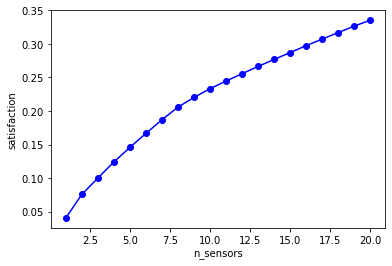

In [15]:
sensors = np.zeros((len(tyne_oa)))

satisfaction_history = []
for s in range(n_sensors):
    # greedily add sensors
    print("Placing sensor", s+1, "out of", n_sensors, "... ", end='')
    
    best_satisfaction = 0
    best_sensors = sensors.copy()
    
    for oa in range(len(tyne_oa)):
        # try adding sensor at each output area
        
        if sensors[oa] == 1:
            # already have a sensor here, so skip to next
            continue
        
        else:
            new_sensors = sensors.copy()
            new_sensors[oa] = 1
            
            # only keep satisfactions due to output areas where a sensor is present
            mask_sat = np.multiply(satisfaction, new_sensors[np.newaxis, :])

            # satisfaction at each output area = satisfaction due to nearest sensor
            max_mask_sat = np.max(mask_sat, axis=1)
            
            # Avg satisfaction = population weighted sum across all output areas
            new_satisfaction = (populations * max_mask_sat).sum() / populations.sum()
            
            if new_satisfaction > best_satisfaction:
                # this output area is the best site for next sensor found so far
                best_sensors = new_sensors.copy()
                best_satisfaction = new_satisfaction
            
    sensors = best_sensors.copy()
    satisfaction_history.append(best_satisfaction)
    print("satisfaction = {:.2f}".format(best_satisfaction))

print("DONE!")
print("Average satisfaction: {:.2f}".format(best_satisfaction))
plt.plot(range(1,n_sensors+1), satisfaction_history, '-bo')
plt.xlabel("n_sensors")
plt.ylabel("satisfaction")

Output areas with sensors: ['E00042043' 'E00042080' 'E00042214' 'E00042255' 'E00042267' 'E00042305'
 'E00042381' 'E00042429' 'E00042447' 'E00042521' 'E00042570' 'E00042621'
 'E00042661' 'E00042662' 'E00042791' 'E00042820' 'E00042846' 'E00042877'
 'E00042886' 'E00175591']


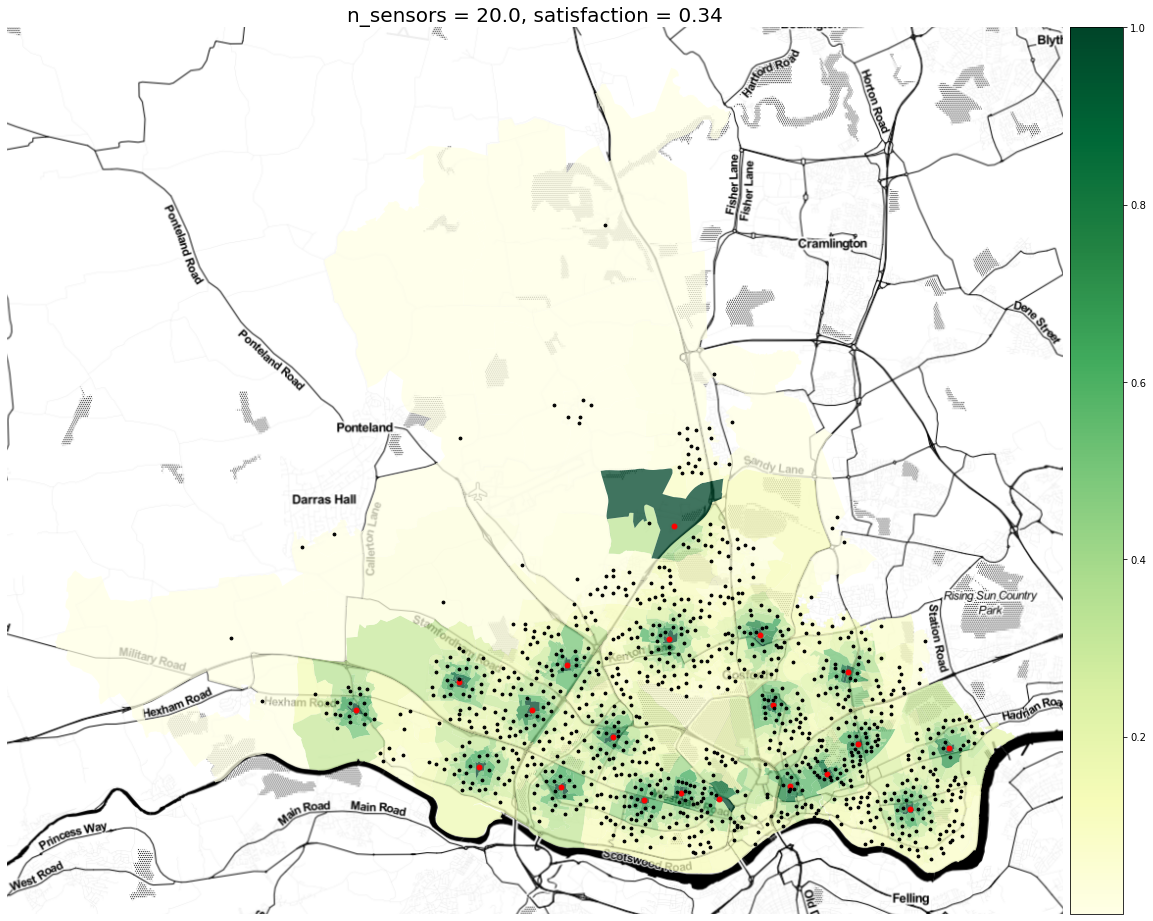

In [16]:
plot_sensors(sensors)

## PyGMO: vector of 0/1s for sensor at location or not

Fails to even meet constraints. But assume it has to "learn" how to make the vector sum up to n_sensors, which seems difficult.

In [17]:
# PyGMO User Defined Problem
class population_optimisation:
    def __init__(self, centroids, populations,
                 n_sensors=10, theta=500):
        
        self.n_sensors = n_sensors
        self.centroids = centroids
        self.populations = populations
        
        # dimension of problem = number of candidate sensor locations
        self.dim = len(populations)
        
        self.distances = self._calc_distances(centroids)

        self.distance_to_satisfaction = np.vectorize(self._scalar_satisfaction)        
        self.satisfaction = self.distance_to_satisfaction(distances, theta=theta)
     
    def fitness(self, sensors):
        """
        PyGMO required function.
        The objective function to minimise. And constraints to evaluate.
        """
        # only keep satisfactions due to output areas where a sensor is present
        mask_sat = np.multiply(satisfaction, sensors[np.newaxis, :])

        # satisfaction at each output area = satisfaction due to nearest sensor
        max_mask_sat = np.max(mask_sat, axis=1)
        
        # Total population-weighted satisfaction of solution = our objective
        fitness_sensors = -(self.populations * max_mask_sat).sum() / self.populations.sum()

        # constraint: have n_sensors sensors
        # equality constraints: must equal zero
        constraint_n_sensors = sensors.sum() - self.n_sensors
        
        return [fitness_sensors, constraint_n_sensors]
    

    def get_bounds(self):
        """
        PyGMO required function.
        Defines min and max value for each parameter.
        """
        return ([0]*self.dim, [1]*self.dim)
    
    def get_nec(self):
        """PyGMO function.
        Defines number of equality constraints."""
        return 1
    
    def get_nix(self):
        """
        PyGMO function.
        Number of integer dimensions.
        """
        return self.dim
    
    def _gradient(self, x):
        return pg.estimate_gradient_h(lambda x: self.fitness(x), x)
    
    def _calc_distances(self, centroids):
        dist_sq = np.sum((centroids[:, np.newaxis, :] - centroids[np.newaxis, :, :]) ** 2,
                 axis = -1)

        distances = np.sqrt(dist_sq)
        
        return distances
    
    def _scalar_satisfaction(self, distance, theta):
        return np.exp(- distance/ theta)
    


In [18]:
# Build problem
prob = pg.problem(
        population_optimisation(centroids,
                                populations,
                                n_sensors,
                                theta)
      )

print(prob)

Problem name: <class '__main__.population_optimisation'>
	Global dimension:			952
	Integer dimension:			952
	Fitness dimension:			2
	Number of objectives:			1
	Equality constraints dimension:		1
	Inequality constraints dimension:	0
	Tolerances on constraints: [0]
	Lower bounds: [0, 0, 0, 0, 0, ... ]
	Upper bounds: [1, 1, 1, 1, 1, ... ]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0

	Thread safety: none



In [19]:
# Create algorithm to solve problem with
algo = pg.algorithm(uda = pg.gaco())
algo.set_verbosity(1)
print(algo)

# population of problems
pop = pg.population(prob=prob, size=100)


Algorithm name: GACO: Ant Colony Optimization [stochastic]
	Thread safety: basic

Extra info:
	Generations: 100
	Accuracy parameter: 0.01
	Improvement stopping criterion: 100000
	Evaluation stopping criterion: 100000
	Focus parameter: 0
	Kernel: 63
	Oracle parameter: 0
	Pseudo-random number generator (Marsenne Twister 19937): 3240878104 905633192 2083543882 50079642 736299462 2637680931 2312579851 2167065492 3052378166 426172557 3013414059 2371579832 972267118 4192755571 3486553918 2095468576 2762360341 2411525668 2555474704 1815414829 3682583920 3828904308 2369680137 4001449582 816586265 2930917622 130167902 339146545 3528441713 4211640855 3536793090 3110252420 1216869886 2923594940 578424088 1724973723 1964011750 2251893320 3962915160 449094670 801257390 3039696335 963923723 3061650050 1874775212 3330954606 2923825455 2026222576 182646597 2697100138 3231537210 2816036784 3393237870 1334255414 3196370921 2558622446 1649527636 4217943490 2648374879 2853249004 2321151778 4238254045 2503

In [20]:
# solve problem
pop = algo.evolve(pop)

print("f evals", pop.problem.get_fevals())
print("g evals", pop.problem.get_gevals())
print("champion f", pop.champion_f)
print("n_sensors", pop.champion_x.sum())
print("min sensors at location", pop.champion_x.min())
print("max sensors at location", pop.champion_x.max())

f evals 10100
g evals 0
champion f [ -0.79232131 390.        ]
n_sensors 410.0
min sensors at location 0.0
max sensors at location 1.0


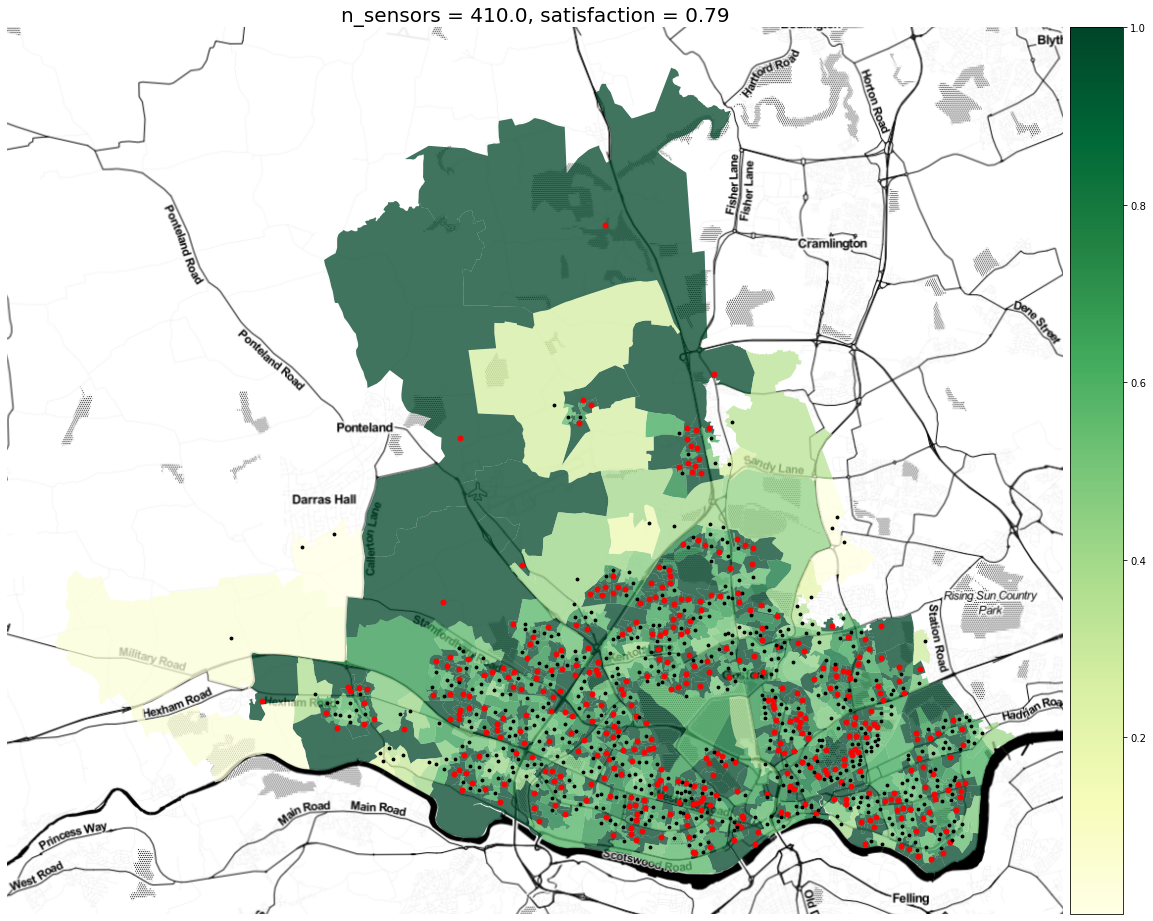

In [21]:
plot_sensors(pop.champion_x, print_sensors=False)

## PyGMO: Sensors at any arbitrary position (not only output area centroids)

In [22]:
# PyGMO User Defined Problem
class population_optimisation:
    def __init__(self, centroids, populations,
                 n_sensors=20, theta=500):
        
        self.n_sensors = n_sensors
        self.centroids = centroids
        self.populations = populations
        
        # dimension of problem = number of candidate sensor locations
        self.dim = len(populations)
        
        self.distances = self._calc_distances(centroids)

        self.distance_to_satisfaction = np.vectorize(self._scalar_satisfaction)        
        self.satisfaction = self.distance_to_satisfaction(distances, theta=theta)
     
    def fitness(self, sensors):
        """
        PyGMO required function.
        The objective function to minimise. And constraints to evaluate.
        """
        # only keep satisfactions due to output areas where a sensor is present
        mask_sat = np.multiply(satisfaction, sensors[np.newaxis, :])

        # satisfaction at each output area = satisfaction due to nearest sensor
        max_mask_sat = np.max(mask_sat, axis=1)
        
        # Total population-weighted satisfaction of solution = our objective
        fitness_sensors = -(self.populations * max_mask_sat).sum() / self.populations.sum()

        # constraint: have n_sensors sensors
        # equality constraints: must equal zero
        constraint_n_sensors = sensors.sum() - self.n_sensors
        
        return [fitness_sensors, constraint_n_sensors]
    

    def get_bounds(self):
        """
        PyGMO required function.
        Defines min and max value for each parameter.
        """
        return ([0]*self.dim, [1]*self.dim)
    
    def get_nec(self):
        """PyGMO function.
        Defines number of equality constraints."""
        return 1
    
    def get_nix(self):
        """
        PyGMO function.
        Number of integer dimensions.
        """
        return self.dim
    
    def _gradient(self, x):
        return pg.estimate_gradient_h(lambda x: self.fitness(x), x)
    
    def _calc_distances(self, centroids):
        dist_sq = np.sum((centroids[:, np.newaxis, :] - centroids[np.newaxis, :, :]) ** 2,
                 axis = -1)

        distances = np.sqrt(dist_sq)
        
        return distances
    
    def _scalar_satisfaction(self, distance, theta):
        return np.exp(- distance/ theta)
    


## MIP

In [23]:
from mip.model import *

Using Python-MIP package version 1.6.4


In [24]:
m = Model()